#  INF8225 Projet QA : HyDE vs RAG-Fusion

## Import des librairies

In [ ]:
import os
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from typing import Optional
from transformers import AutoTokenizer, AutoModel, AutoModelForCausalLM, pipeline, BitsAndBytesConfig
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer
from nltk.translate.bleu_score import sentence_bleu
import nltk
import faiss
import torch.nn.functional as F
from torch.utils.data import Dataset

import os
import torch
from torch.utils.data import DataLoader
from transformers import AdamW
from tqdm import tqdm
import random

## Déclarations des constantes

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 16

## Chargement des données

In [3]:
root_path = './'
data_path = root_path + 'data/'
questions_test = pd.read_csv(data_path + 'questions_test.csv')
questions_train = pd.read_csv(data_path+'questions_train.csv')
questions_val = pd.read_csv(data_path+'questions_val.csv')
texts = pd.read_csv(data_path + 'texts.csv')

# Colonnes utiles
passages = texts['text'].tolist()
questions_t = questions_test['question'].tolist()
questions_tr = questions_train['question'].tolist()
questions_v = questions_val['question'].tolist()

## Encoding

### Chargement de l'encodeur

In [4]:
from transformers import AutoTokenizer, AutoModel
model_name = 'BAAI/bge-base-en-v1.5'
emb_tokenizer = AutoTokenizer.from_pretrained(model_name)
emb_model = AutoModel.from_pretrained(model_name)
emb_model.to(DEVICE)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [5]:
from peft import LoraConfig, get_peft_model

lora_config = LoraConfig(
    r=16,
    lora_alpha=16,
    target_modules=["query", "key", "value"],
    lora_dropout=0.05,
    bias="none",
)

emb_model = get_peft_model(emb_model, lora_config)

In [6]:
emb_model.load_state_dict(torch.load("models_encoder/fine_tuned_model_weights_epoch_8.pth"))

<All keys matched successfully>

### Stockage dans FAISS

In [7]:
def encode_sequences(sequences: list, tokenizer, model, device=DEVICE, batch_size=BATCH_SIZE, training=False) -> torch.Tensor:
    model.train() if training else model.eval()
    context = torch.enable_grad() if training else torch.no_grad()

    embeddings = []
    with context:
        for i in range(0, len(sequences), batch_size):
            batch = sequences[i:i + batch_size]

            # Tokenisation des textes avant entrée du modèle
            inputs = tokenizer(
                batch, padding=True, truncation=True, return_tensors="pt"
            ).to(device)

            # Passage dans le modèle encodeur
            output = model(**inputs).last_hidden_state

            # Pooling : moyenne des vecteurs de tous les tokens pour chaque séquence
            pooled = output.mean(dim=1)  # [batch_size, hidden_size]

            embeddings.append(pooled)

    # Concatène tous les embeddings pour obtenir un seul tensor de sortie
    return torch.cat(embeddings, dim=0)

In [8]:
passage_embed = encode_sequences(passages, emb_tokenizer, emb_model)
passage_embeddings = passage_embed.cpu().numpy()
faiss.normalize_L2(passage_embeddings) #  Normalisation des vecteurs pour l'approche similarité cosinus
d = passage_embeddings.shape[1]
index = faiss.IndexFlatIP(d)  # Index Faiss
index.add(passage_embeddings)

c:\Users\mathi\anaconda3\envs\ml_env\Lib\site-packages\transformers\models\bert\modeling_bert.py:440: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


In [9]:
def retrieve_top_k_passages_faiss(questions: list, vector_index: faiss.IndexFlatL2, embedding_model_tokenizer, embedding_model, k: int):
    question_embeddings = encode_sequences(questions, embedding_model_tokenizer, embedding_model)
    question_embeddings = question_embeddings.cpu().numpy()
    faiss.normalize_L2(question_embeddings)
    _, top_k_indices = vector_index.search(question_embeddings, k)
    
    return top_k_indices

## RAG Fusion

### Rephrasing

In [10]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

model_name = "google/flan-t5-base"
rag_fus_tokenizer = AutoTokenizer.from_pretrained(model_name)
rag_fus_model = AutoModelForSeq2SeqLM.from_pretrained(model_name, device_map="auto", torch_dtype=torch.float16)
rag_fus_model.to(DEVICE)

T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseGatedActDense(
              (wi_0): Linear(in_features=768, out_features=2048, bias=False)
              (wi_1): Linear(in_features=768, out_features=2048, bias=False)
              (wo):

In [34]:
def generate_reformulations_flant5(question, model, tokenizer, n=5):
    prompt_template = (
        f"Question: {question.strip()}\n\n"
        "Rephrase this question in a different way"
    )
    return [
        tokenizer.decode(
            model.generate(
                **tokenizer(prompt_template, return_tensors="pt").to(model.device),
                max_new_tokens=64,
                do_sample=True,
                top_k=50,
                top_p=0.95,
                temperature=0.9,
            )[0],
            skip_special_tokens=True,
        )
        for _ in range(n)
    ]

In [12]:
from transformers import T5ForConditionalGeneration,T5Tokenizer

rag_fus_model2 = T5ForConditionalGeneration.from_pretrained('ramsrigouthamg/t5_paraphraser')
rag_fus_tokenizer2 = T5Tokenizer.from_pretrained('ramsrigouthamg/t5_paraphraser')
rag_fus_model2 = rag_fus_model2.to(DEVICE)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [33]:
def generate_reformulations_t5paraphraser(question, model, tokenizer, n=5):
    text = f"paraphrase: {question} </s>"
    encoding = tokenizer.encode_plus(
        text, return_tensors="pt", padding=True, truncation=True, max_length=256
    ).to(model.device)

    outputs = model.generate(
        input_ids=encoding["input_ids"],
        attention_mask=encoding["attention_mask"],
        do_sample=True,
        max_length=256,
        top_k=120,
        top_p=0.98,
        early_stopping=True,
        num_return_sequences=n * 2  # générer plus et filtrer les doublons
    )

    results = []
    for output in outputs:
        decoded = tokenizer.decode(output, skip_special_tokens=True)
        if decoded.lower() != question.lower() and decoded not in results:
            results.append(decoded)
        if len(results) >= n:
            break
    return results

In [32]:
def generate_reformulations(question, model, tokenizer, method="flant5", n=5):
    if method == "flant5":
        return generate_reformulations_flant5(question, model, tokenizer, n)
    elif method == "paraphraser":
        return generate_reformulations_t5paraphraser(question, model, tokenizer, n)

### Reranking

In [38]:
from sentence_transformers import CrossEncoder
reranker = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2', device=DEVICE)

#### Affinage du reranker

In [39]:
from sentence_transformers import InputExample
from sentence_transformers.cross_encoder.evaluation import CERerankingEvaluator


def build_reranker_training_data(questions_df, texts_df, all_passage_ids, neg_ratio=4):
    training_data = []

    for _, entry in questions_df.iterrows():
        question = entry["question"]
        passage_ids = [int(pid) for pid in entry["text_ids"].strip('[]').split()]

        # Positives
        for pid in passage_ids:
            passage = texts_df.loc[texts_df["id"] == pid, "text"].values[0]
            training_data.append((question, passage, 1.0))

        # Negatives
        negative_ids = list(all_passage_ids - set(passage_ids))
        sampled_neg_ids = random.sample(negative_ids, min(neg_ratio * len(passage_ids), len(negative_ids)))
        for pid in sampled_neg_ids:
            passage = texts_df.loc[texts_df["id"] == pid, "text"].values[0]
            training_data.append((question, passage, 0.0))
    
    return training_data

def build_reranker_val_samples(questions_df, texts_df, all_passage_ids, neg_ratio=4):
    val_samples = []

    for _, entry in questions_df.iterrows():
        question = entry["question"]
        passage_ids = [int(pid) for pid in entry["text_ids"].strip('[]').split()]

        positives = [
            texts_df.loc[texts_df["id"] == pid, "text"].values[0]
            for pid in passage_ids
        ]

        negative_ids = list(all_passage_ids - set(passage_ids))
        negatives = random.sample(negative_ids, min(neg_ratio * len(passage_ids), len(negative_ids)))
        negatives = [
            texts_df.loc[texts_df["id"] == pid, "text"].values[0]
            for pid in negatives
        ]

        val_samples.append({"query": question, "positive": positives, "negative": negatives})
    
    return val_samples


def convert_to_input_examples(data_tuples):
    return [
        InputExample(texts=[question, passage], label=score)
        for question, passage, score in data_tuples
    ]

def fine_tune_reranker(train_examples, val_samples, model_name, output_path, batch_size=8, epochs=8):
    reranker = CrossEncoder(model_name, num_labels=1)

    train_loader = DataLoader(train_examples, shuffle=True, batch_size=batch_size)
    evaluator = CERerankingEvaluator(val_samples, name="eval")

    reranker.fit(
        train_dataloader=train_loader,
        evaluator=evaluator,
        evaluation_steps=1000,
        epochs=epochs,
        warmup_steps=500,
        output_path=output_path
    )

    return CrossEncoder(output_path)

In [40]:
all_passage_ids = set(texts["id"].values)
train_data = build_reranker_training_data(questions_train, texts, all_passage_ids)
train_examples = convert_to_input_examples(train_data)

val_samples = build_reranker_val_samples(questions_val, texts, all_passage_ids)

# Fine-tuning
fine_tuned_reranker = fine_tune_reranker(
    train_examples,
    val_samples,
    model_name="cross-encoder/ms-marco-MiniLM-L-6-v2",
    output_path="./fine_tuned_crossencoder"
)

Epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3100 [00:00<?, ?it/s]

#### Fonction de rerank

In [41]:
fine_tuned_reranker = CrossEncoder('./fine_tuned_crossencoder')

In [54]:
def rerank_passages(question, passage_ids, reranker_model, top_k=None):
    passages = texts[texts['id'].isin(passage_ids)]['text'].tolist()
    pairs = [(question, passage) for passage in passages]
    scores = reranker_model.predict(pairs)
    
    sorted_pairs = sorted(zip(scores, passages), reverse=True)
    top_passages = sorted_pairs[:top_k] if top_k else sorted_pairs

    final_ids = []
    for _, passage in top_passages:
        match = texts.loc[texts['text'] == passage, 'id'].values
        if len(match) > 0:
            final_ids.append(match[0])
    return final_ids

## RAG Fusion Pipeline

In [ ]:
# def retrieve_rag_fusion(question, model, tokenizer, faiss_index, emb_model, emb_tokenizer, k=5, reform_method="flant5", n_reform=5):
#     reformulations = generate_reformulations(question, model, tokenizer, reform_method, n_reform)
    
#     # Récupérer les passages pour chaque reformulation
#     all_indices = []
#     for q in reformulations:
#         top_ids = retrieve_top_k_passages_faiss([q], faiss_index, emb_tokenizer, emb_model, k)[0]
#         print(q)
#         print(top_ids)
#         all_indices.extend(top_ids.tolist())

#     # Supprimer les doublons
#     unique_indices = list(set(all_indices))
#     return unique_indices

# def run_rag_fusion_pipeline(questions, reform_model, reform_tokenizer, reform_method, faiss_index, emb_model, emb_tokenizer, reranker_model, k=5, n_reform=5):
#     results = {}
#     for q_index, question in enumerate(questions):
#         print(f"[{q_index+1}/{len(questions)}] Processing question: {question}")
#         retrieved_ids = retrieve_rag_fusion(
#             question,
#             reform_model,
#             reform_tokenizer,
#             faiss_index,
#             emb_model,
#             emb_tokenizer,
#             k=k,
#             reform_method=reform_method,
#             n_reform=n_reform
#         )
#         reranked_ids = rerank_passages(question, retrieved_ids, reranker_model, top_k=k)
#         results[question] = reranked_ids
#     return results

from collections import defaultdict

def retrieve_rag_fusion_rrf(question, model, tokenizer, faiss_index, emb_model, emb_tokenizer, 
                            k=5, reform_method="flant5", n_reform=5, rrf_k=60, prefilter_top_n=20):
    reformulations = generate_reformulations(question, model, tokenizer, reform_method, n_reform)

    # RRF fusion
    rrf_scores = defaultdict(float)
    for q in reformulations:
        top_ids = retrieve_top_k_passages_faiss([q], faiss_index, emb_tokenizer, emb_model, k)[0]
        for rank, passage_id in enumerate(top_ids):
            score = 1 / (rank + 1 + rrf_k)
            rrf_scores[passage_id] += score

    # Trier et retourner les top-N documents
    sorted_ids = [doc_id for doc_id, _ in sorted(rrf_scores.items(), key=lambda x: x[1], reverse=True)]
    return sorted_ids[:prefilter_top_n]


def run_rag_fusion_pipeline_rrf(questions, reform_model, reform_tokenizer, reform_method, 
                                faiss_index, emb_model, emb_tokenizer, reranker_model, 
                                k=5, n_reform=5, rrf_k=60, prefilter_top_n=20):
    results = {}
    for q_index, question in enumerate(questions):
        print(f"[{q_index+1}/{len(questions)}] Processing question: {question}")
        
        retrieved_ids = retrieve_rag_fusion_rrf(
            question,
            reform_model,
            reform_tokenizer,
            faiss_index,
            emb_model,
            emb_tokenizer,
            k=k,
            reform_method=reform_method,
            n_reform=n_reform,
            rrf_k=rrf_k,
            prefilter_top_n=prefilter_top_n
        )

        reranked_ids = rerank_passages(question, retrieved_ids, reranker_model, top_k=k)
        results[question] = reranked_ids
    return results

In [ ]:
# reform_method = "flant5"
reform_method = "paraphraser"

# results = run_rag_fusion_pipeline(
#     questions=questions_v,            
#     reform_model=rag_fus_model2,
#     reform_tokenizer=rag_fus_tokenizer2,
#     reform_method=reform_method,
#     faiss_index=index,
#     emb_model=emb_model,
#     emb_tokenizer=emb_tokenizer,
#     reranker_model=fine_tuned_reranker,
#     k=5,
#     n_reform=5
# )

results = run_rag_fusion_pipeline_rrf(
    questions=questions_v,            
    reform_model=rag_fus_model2,
    reform_tokenizer=rag_fus_tokenizer2,
    reform_method=reform_method,
    faiss_index=index,
    emb_model=emb_model,
    emb_tokenizer=emb_tokenizer,
    reranker_model=fine_tuned_reranker,
    k=5,
    n_reform=5,
    rrf_k=60,
    prefilter_top_n=30   # combien de passages on rerank après RRF
)

print(results)

[1/500] Processing question: What is the effect of the M201V variant of CYSLTR2 on responsiveness to LTD4?
[2/500] Processing question: What is the key difference in the structure of carbapenems compared to penicillins?
[3/500] Processing question: What type of facets are there in the 8-demicubic honeycomb?
[4/500] Processing question: What is the legal status of 5F-AMB in the United States?
[5/500] Processing question: What is converted into estrone sulfamate by 17β-hydroxysteroid dehydrogenase?
[6/500] Processing question: What receptors does 3-HO-PCP have high affinity for?
[7/500] Processing question: What is the location of the PAI-1 gene?
[8/500] Processing question: What type of substance is 5F-AMB?
[9/500] Processing question: What binds to the NMDA receptor with higher affinity than PCP?
[10/500] Processing question: What type of anion is BARF?
[11/500] Processing question: What is the approximation for the electron heat capacity?
[12/500] Processing question: What is the prim

### Evaluation

Precision@1 = 0.902
Recall@1 = 0.34

Precision@2 = 0.662
Recall@2 = 0.483

Precision@3 = 0.561
Recall@3 = 0.605

Precision@4 = 0.508
Recall@4 = 0.724

Precision@5 = 0.461
Recall@5 = 0.815



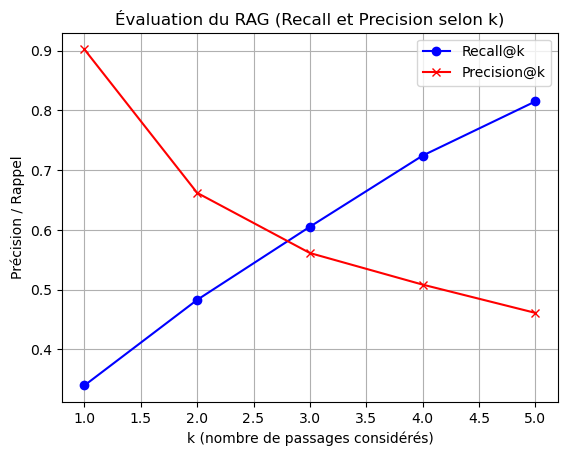

In [56]:
def compute_recall_at_k(ground_truth, predictions):
    total_recall = 0
    for true_texts, predicted_texts in zip(ground_truth, predictions):

        true_set = set(true_texts)  
        predicted_set = set(predicted_texts)

        relevant_and_retrieved = true_set.intersection(predicted_set)
        
        recall = len(relevant_and_retrieved) / len(true_set)
        total_recall += recall
   
    average_recall = total_recall / len(ground_truth) 
    return average_recall


def compute_precision_at_k(ground_truth, predictions):
    total_precision = 0
    for true_texts, predicted_texts in zip(ground_truth, predictions):
        true_set = set(true_texts)
        predicted_set = set(predicted_texts)
        relevant_and_retrieved = true_set.intersection(predicted_set)
        
        precision = len(relevant_and_retrieved) / len(predicted_set) 
        total_precision += precision
    
    average_precision = total_precision / len(ground_truth) 
    return average_precision

top_ground_truth = questions_val['text_ids'].apply(lambda x: [int(num) for num in x.strip('[]').split()]).to_list()

k_values = range(1, 6)
recall = []
precision = []

for k in k_values:
    top_passages_k = [
        results[q][:k] if q in results else []
        for q in questions_v
    ]
    
    rec_at_k = compute_recall_at_k(top_ground_truth, top_passages_k)
    prec_at_k = compute_precision_at_k(top_ground_truth, top_passages_k)

    recall.append(rec_at_k)
    precision.append(prec_at_k)

    print(f'Precision@{k} = {round(prec_at_k, 3)}')
    print(f'Recall@{k} = {round(rec_at_k, 3)}\n')

plt.plot(k_values, recall, marker='o', color='b', label='Recall@k')
plt.plot(k_values, precision, marker='x', color='r', label='Precision@k')
plt.xlabel('k (nombre de passages considérés)')
plt.ylabel('Précision / Rappel')
plt.title('Évaluation du RAG (Recall et Precision selon k)')
plt.legend()
plt.grid(True)
plt.show()